In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
import itertools
import subprocess
from time import time
from scipy import stats
import scipy.optimize as opt
from scipy.stats import chi2_contingency
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [2]:
# read data
data = pd.read_csv("Near Earth Objects.csv") 

data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
# dimensions
data.shape

(90836, 10)

In [4]:
# check data pt 1
data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [5]:
# check data pt 2
data.tail()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False
90835,54205447,(2021 TW7),0.039862,0.089133,27024.455553,5.977213e+07,Earth,False,24.12,False


In [6]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
# data descriptors
data.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [8]:
# checking for null values
data.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [9]:
# one hot encoding

from sklearn.preprocessing import LabelEncoder
# instantiate LabelEncoder
le = LabelEncoder()

for val in data:
    # compare if the dtype is object
    if data[val].dtypes=='object':
        data[val]=le.fit_transform(data[val])


In [10]:
data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,24991,1.198271,2.679415,13569.249224,5.483974e+07,0,False,16.73,False
1,2277475,25414,0.265800,0.594347,73588.726663,6.143813e+07,0,False,20.00,True
2,2512244,26799,0.722030,1.614507,114258.692129,4.979872e+07,0,False,17.83,False
3,3596030,5505,0.096506,0.215794,24764.303138,2.543497e+07,0,False,22.20,False
4,3667127,7518,0.255009,0.570217,42737.733765,4.627557e+07,0,False,20.09,True


In [11]:
# copy data
data1 = data.copy()

In [12]:
# converting bool to number for sentry_object

data1.loc[:, 'sentry_object'] = data1.loc[:, 'sentry_object'].apply(lambda x: 1 if x == True else 0)

In [13]:
# converting bool to number for hazardous

data1.loc[:, 'hazardous'] = data1.loc[:, 'hazardous'].apply(lambda x: 1 if x == True else 0)

In [14]:
data1.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,24991,1.198271,2.679415,13569.249224,5.483974e+07,0,0,16.73,0
1,2277475,25414,0.265800,0.594347,73588.726663,6.143813e+07,0,0,20.00,1
2,2512244,26799,0.722030,1.614507,114258.692129,4.979872e+07,0,0,17.83,0
3,3596030,5505,0.096506,0.215794,24764.303138,2.543497e+07,0,0,22.20,0
4,3667127,7518,0.255009,0.570217,42737.733765,4.627557e+07,0,0,20.09,1


In [15]:
# remove irrelevant data
data1 = data1.drop(['orbiting_body','sentry_object'], axis=1)

<AxesSubplot:>

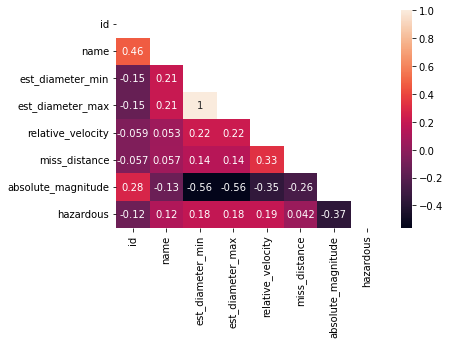

In [16]:
# heatmap
mask = np.triu(np.ones_like(data1.corr(), dtype=bool))
sns.heatmap(data1.corr(),mask = mask ,annot=True)

In [17]:
# feature importance

model = RandomForestClassifier()

features = data1[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
 
model.fit(features, data1['hazardous'])
 
feature_importances=pd.DataFrame({'features':features.columns,'feature_importance':model.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
3,miss_distance,0.304201
2,relative_velocity,0.268924
0,est_diameter_min,0.151322
1,est_diameter_max,0.140714
4,absolute_magnitude,0.134839


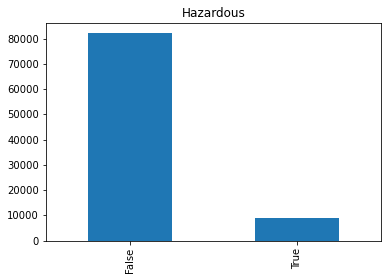

In [18]:
# plot distribution of hazardous asteroids
data.hazardous.value_counts().plot(kind='bar')
plt.title('Hazardous')
plt.show()

In [19]:
# train test split

import statsmodels.api as sm

spacetrain, spacetest = train_test_split(data1, train_size=0.70, random_state=1)

# train: independent and dependent variables
X_train = spacetrain[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
y_train = spacetrain[['hazardous']]

# test: independent and dependent variables 
X_test = spacetest[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
y_test = spacetest[['hazardous']]

# scaling data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit model to the train set
logreg.fit(rescaledX_train, y_train)

/Users/CozYNut/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [21]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
random_state=None, solver='warn', tol=0.0001, verbose=0,warm_start=False)

LogisticRegression(multi_class='warn', solver='warn')

In [22]:
# logreg model

from sklearn.metrics import (confusion_matrix, accuracy_score)
yhat = logreg.predict(rescaledX_test)

# confusion matrix
cm = confusion_matrix(yhat, y_test)
print("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Score = ', round(accuracy_score(yhat, y_test) * 100, 2))

Confusion Matrix : 
 [[24375  2512]
 [  240   124]]
Score =  89.9


In [ ]:
# support vector machine

from sklearn import svm

clf = svm.SVC(kernel = 'linear')
clf.fit(rescaledX_train, y_train)
prediction2 = clf.predict(rescaledX_test)


# confusion matrix
cm2 = confusion_matrix(y_test, prediction2)
print ("Confusion Matrix: \n", cm2)

# accuracy
print("Score = ", round(accuracy_score(y_test, prediction2) * 100, 2))

/Users/CozYNut/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# random forest

clf2 = RandomForestClassifier(n_estimators = 100)

clf2.fit(rescaledX_train, y_train)

prediction3 = clf2.predict(rescaledX_test)

from sklearn import metrics

# confussion matrix
cm3 = confusion_matrix(y_test, prediction3)
print ("Confusion Matrix: \n", cm3)

# accuracy
print("Score = ", round(accuracy_score(y_test, prediction3) * 100, 2))